# Description

## SFC Requests Placed

Compute the requests placed

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Path to the Results folder inside the docker container
path_results = "../logs"

hue_order = ["Random", "Greedy", "Speed"]

def connect_dataframe(pda, num_requests, label, rnd):
    global hue_order
    pda['Num_Requests'] = num_requests
    pda['Label'] = label
    pda['Round'] = rnd

    return pda

def load_data():

    num_requests = dict()

    experiments = list(filter(lambda x: os.path.isdir(os.path.join(path_results, x)), os.listdir(path_results)))

    requests = []
    data_aggregation = []
    for exp in experiments:
        aux = exp.split("_")
        num_requests[int(aux[0])] = int(aux[0])

        for alg in hue_order:
            # distributed placement
            exp_file = "{}/{}/{}/distributed_placement.csv".format(path_results, exp, alg.lower())
            requests.append(connect_dataframe(
                pd.read_csv(exp_file, sep=';'),
                int(aux[0]),
                alg,
                int(aux[1]),
            ))

            # data aggregation
            exp_file = "{}/{}/{}/data_aggregation.csv".format(path_results, exp, alg.lower())
            data_aggregation.append(connect_dataframe(
                pd.read_csv(exp_file, sep=';'),
                int(aux[0]),
                alg,
                int(aux[1]),
            ))

    o = list(num_requests.keys())

    data = {
        'requests': requests,
        'data_aggregation': data_aggregation,
        'order': o
    }

    return data

# Process Data

Return the percentage of success placement

In [80]:
def process_data():
    data = load_data()

    entities = data['requests']

    services_processed = []

    for services in entities:
        df = services.loc[(services['Event'] == "SUCCESS")]
        services_processed.append(df)

    res = pd.concat(services_processed)

    grouped_data = res.groupby(['Label', 'Num_Requests', 'Round','Event']).count().reset_index()

    grouped_data["percentage"] = (grouped_data['Time'] / grouped_data['Num_Requests']) * 10

    return grouped_data
# df_summed = process_data_cost()
# df_summed

## Service Placed

Print the service success rate placement graph

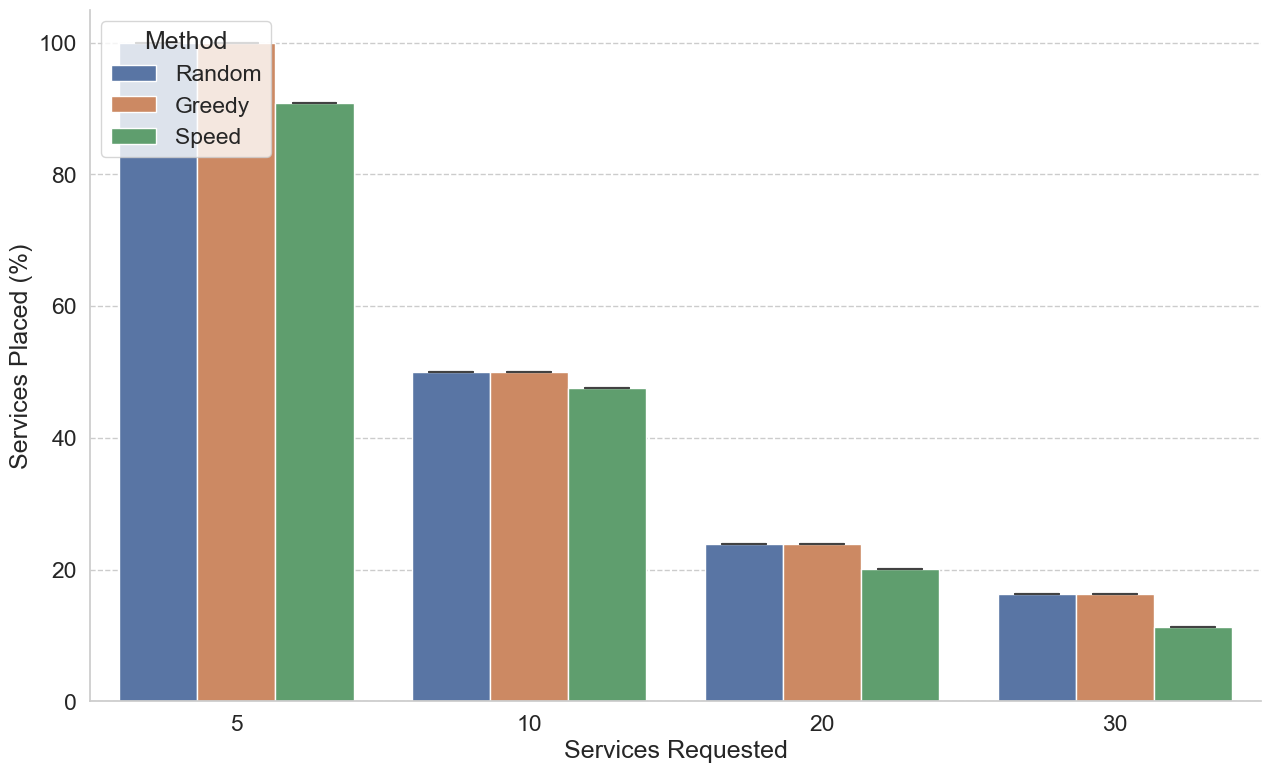

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale = 1.5)

sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.color_palette("rocket")

loaded_data = load_data()

order = sorted(loaded_data['order'])

df_summed = process_data()

g = sns.catplot(
    data=df_summed,
    kind="bar",
    hue="Label",
    order = order,
    hue_order=hue_order,
    x="Num_Requests",
    y="percentage",
    errorbar=('ci', 0.95),
    capsize=.15,
    errwidth=1.5,
    legend_out=False
)

g.fig.set_figheight(9)
g.fig.set_figwidth(16)

g.set_axis_labels("Services Requested", "Services Placed (%)")
plt.legend(loc='upper left', title='Method')

plt.show()

g.figure.savefig(fname='./services_placed.pdf', transparent=False, pad_inches=0.3, bbox_inches='tight')

In [82]:
def process_data_cost():
    data = load_data()

    entities = data['requests']

    services_processed = []

    for services in entities:
        df = services.loc[(services['Event'] == "SUCCESS")]
        services_processed.append(df)

    res = pd.concat(services_processed)

    grouped_data = res.groupby(['Label', 'Num_Requests','Round']).mean(['Cost']).reset_index()

    # grouped_data["cost_dollar"] = (grouped_data['Cost'] / 100)
    grouped_data["cost_dollar"] = (grouped_data['Cost'] / 1)

    return grouped_data

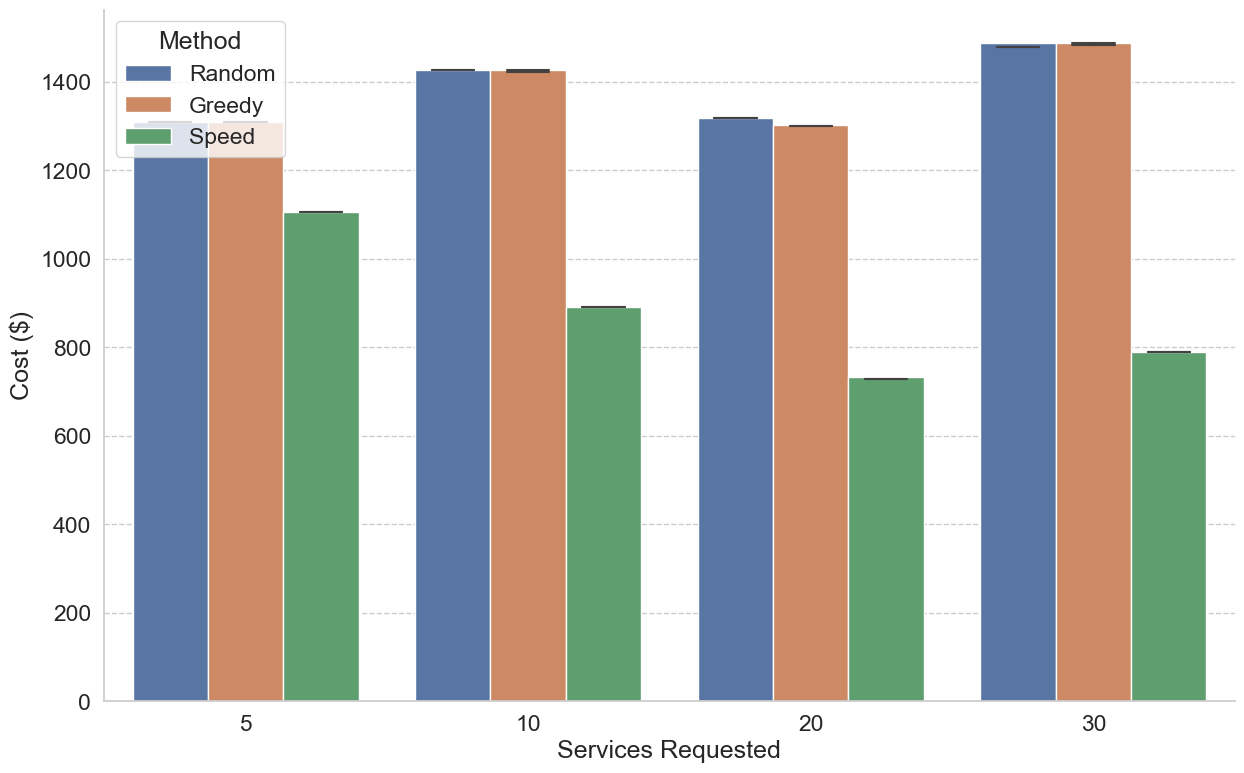

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale = 1.5)

sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.color_palette("rocket")

loaded_data = load_data()

order = sorted(loaded_data['order'])

df_summed = process_data_cost()

g = sns.catplot(
    data=df_summed,
    kind="bar",
    hue="Label",
    order = order,
    hue_order=hue_order,
    x="Num_Requests",
    y="cost_dollar",
    errorbar=('ci', 0.95),
    capsize=.15,
    errwidth=1.5,
    legend_out=False
)

g.fig.set_figheight(9)
g.fig.set_figwidth(16)

g.set_axis_labels("Services Requested", "Cost ($)")
plt.legend(loc='upper left', title='Method')

plt.show()

g.figure.savefig(fname='./services_cost.pdf', transparent=False, pad_inches=0.3, bbox_inches='tight')

In [84]:
def process_data_placement_time():
    data = load_data()

    entities = data['requests']

    services_processed = []

    for services in entities:
        df = services.loc[(services['Event'] == "SUCCESS") & (services['Label'] == "Speed")]
        services_processed.append(df)

    res = pd.concat(services_processed)

    grouped_data = res.groupby(['Label', 'Num_Requests'],  observed=True).mean(["Placement_Time"]).reset_index()

    return grouped_data

df_summed = process_data_placement_time()
df_summed.describe()

,Num_Requests,Time,Cost,Placement_Time,Round
count,4.000000,4.000000,4.000000,4.000000,4.000000
mean,16.250000,21.610727,866.807290,21.610727,2.052137
std,11.086779,7.392448,168.584410,7.392448,0.136082
min,5.000000,12.123348,739.764706,12.123348,1.890547
25%,8.750000,19.285039,743.523266,19.285039,2.005676
50%,15.000000,22.077428,814.194782,22.077428,2.047237
75%,22.500000,24.403117,937.478807,24.403117,2.093697
max,30.000000,30.164706,1099.074890,30.164706,2.223529


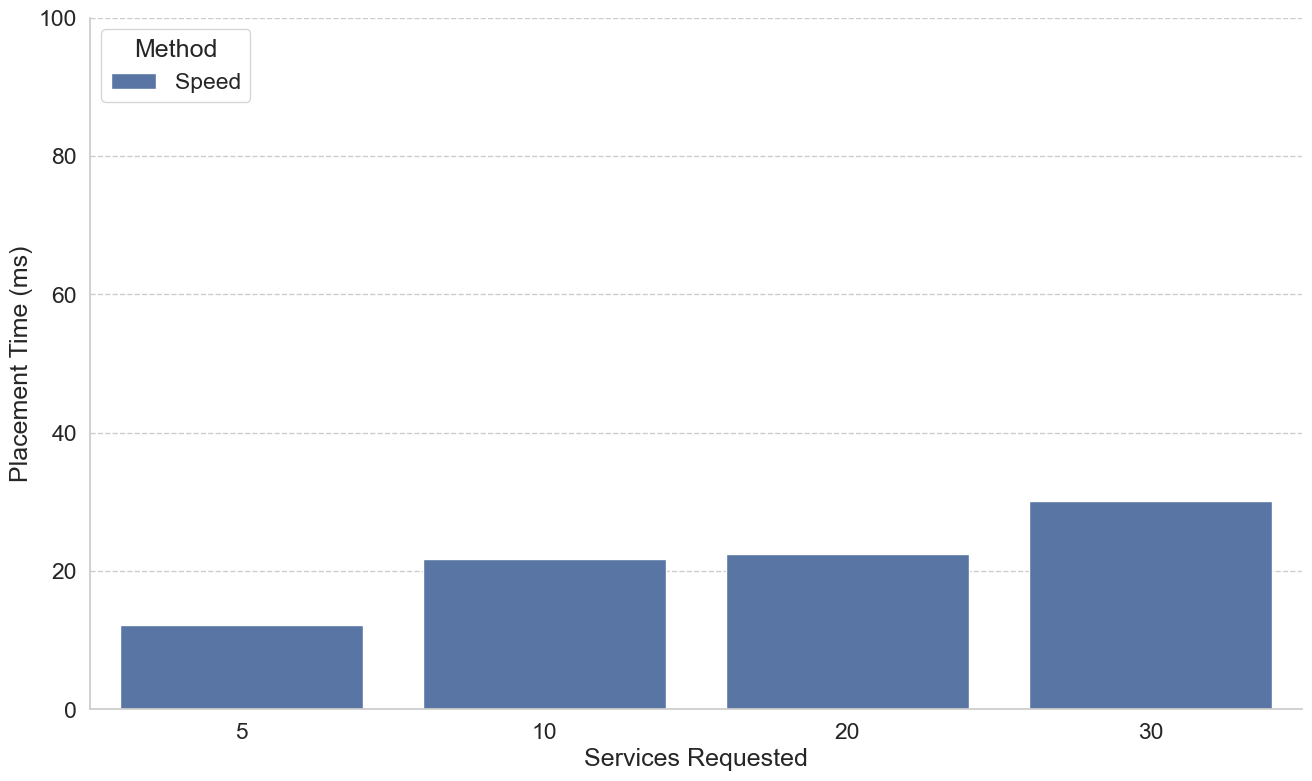

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale = 1.5)

sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.color_palette("rocket")

loaded_data = load_data()

order = sorted(loaded_data['order'])

df_summed = process_data_placement_time()

g = sns.catplot(
    data=df_summed,
    kind="bar",
    hue="Label",
    x="Num_Requests",
    y="Placement_Time",
    errorbar=('ci', 0.95),
    capsize=.15,
    errwidth=1.5,
    legend_out=False
)

g.set(ylim=(0, 100))

g.fig.set_figheight(9)
g.fig.set_figwidth(16)

g.set_axis_labels("Services Requested", "Placement Time (ms)")
plt.legend(loc='upper left', title='Method')

plt.legend(loc='upper left', title='Method')

plt.show()

g.figure.savefig(fname='./placement_time.pdf', transparent=False, pad_inches=0.3, bbox_inches='tight')

# Compute Aggregation Data Size

Compute the size of the data exchanged between the zones to execute the placement

In [86]:
def process_data_size():
    data = load_data()
    entities = data['data_aggregation']
    services_processed = []
    for services in entities:
        df = services.loc[(services['Label'] == "Speed")]
        services_processed.append(df)

    gd = pd.concat(services_processed)

    gd = gd.groupby(['Label', 'Num_Requests'],  observed=True).sum(["Size"]).reset_index()

    gd["Size"] = gd['Size'] / 1000000

    return gd

data = process_data_size()
data

,Label,Num_Requests,Time,Size,Round
0,Speed,5,47030.0,59.6392,25500
1,Speed,10,83175.0,180.8856,38985
2,Speed,20,205650.0,725.6136,77850
3,Speed,30,557280.0,1167.5008,125200


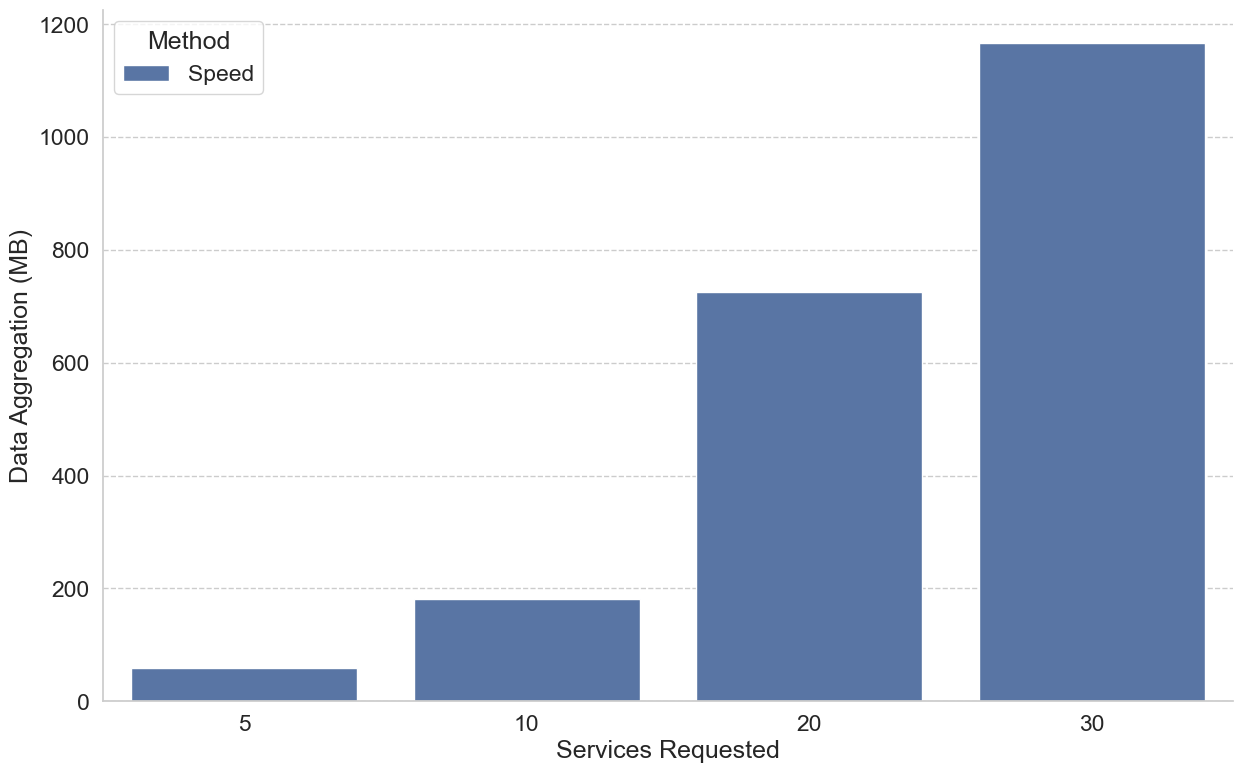

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale = 1.5)

sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.color_palette("rocket")

loaded_data = load_data()

order = sorted(loaded_data['order'])

df_summed = process_data_size()

g = sns.catplot(
    data=df_summed,
    kind="bar",
    hue="Label",
    x="Num_Requests",
    y="Size",
    errorbar=('ci', 0.95),
    capsize=.15,
    errwidth=1.5,
    legend_out=False
)

g.fig.set_figheight(9)
g.fig.set_figwidth(16)

g.set_axis_labels("Services Requested", "Data Aggregation (MB)")
plt.legend(loc='upper left', title='Method')

plt.show()

g.figure.savefig(fname='./data_aggregation_size.pdf', transparent=False, pad_inches=0.3, bbox_inches='tight')